In [1]:
import sys
sys.path.append('../../../')
sys.path.append('/home/sheida.rahnamai/GIT/HDN/')
import torch
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tifffile import imread
import glob
import matplotlib.patches as patches
import hdbscan as hd
from sklearn.preprocessing import StandardScaler
from hdbscan import prediction
from sklearn.cluster import HDBSCAN
from collections import Counter
from openTSNE import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
from lib import plotting as p
from lib import dataprep as dp
import random
import umap
from tqdm import tqdm
from lib.evaluation import FeatureExtractor

/localscratch/emseg_ls/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

patch_size = 64
sample_size = 100
centre_size = 4
n_channel = 32
hierarchy_level = 3
pad_size = (patch_size - centre_size) // 2
model_dir = "/group/jug/Sheida/HVAE/Hyperparameter_search/legendary-violet-547-2nd-cl1e-3_kl1/"
model = torch.load(model_dir+"model/Contrastive_MAE_best_vae.net")

In [3]:
from lib.dataloader import CustomDataset
import tifffile as tiff
from sklearn.utils import shuffle


# train data

data_dir = "/localscratch/contrastive/"
train_img_dir = sorted(glob.glob(data_dir+"train/mito_golgi_gra/*.tif"))
train_images = tiff.imread(train_img_dir)
train_label_dir = sorted(glob.glob(data_dir+"train/label_mito_golgi_gra/*.tif"))
train_labels = tiff.imread(train_label_dir)



train_images, train_labels = shuffle(train_images, train_labels)

data_mean = np.mean(train_images)
data_std = np.std(train_images)
train_images = (train_images-data_mean)/data_std
train_set = CustomDataset(train_images, train_labels)

golgi_indices = random.sample(train_set.patches_by_label[1],sample_size)
mito_indices = random.sample(train_set.patches_by_label[2],sample_size)
gra_indices = random.sample(train_set.patches_by_label[3],sample_size)

golgi_samples, golgi_cls, golgi_lbl = train_set[golgi_indices]
mito_samples, mito_cls, mito_lbl = train_set[mito_indices]
gra_samples, gra_cls, gra_lbl = train_set[gra_indices]

golgi_samples = golgi_samples.squeeze(1)
golgi_lbl = golgi_lbl.squeeze(1)
mito_samples = mito_samples.squeeze(1)
mito_lbl = mito_lbl.squeeze(1)
gra_samples = gra_samples.squeeze(1)
gra_lbl = gra_lbl.squeeze(1)

#test data

test_img_dir = sorted(glob.glob(data_dir+"test/mito_golgi_gra/*.tif"))
test_images = tiff.imread(test_img_dir)
test_label_dir = sorted(glob.glob(data_dir+"test/label_mito_golgi_gra/*.tif"))
test_labels = tiff.imread(test_label_dir)

data_mean = np.mean(test_images)
data_std = np.std(test_images)
test_images = (test_images-data_mean)/data_std

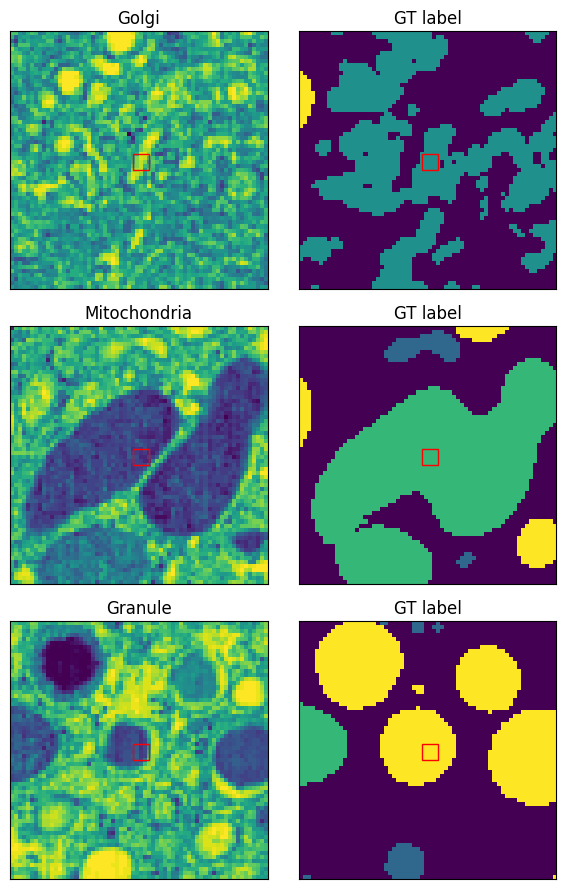

In [4]:
i, j, k = np.random.randint(0, sample_size, 3)
p.plot((golgi_samples[i], "Golgi", (pad_size, pad_size, centre_size)),\
        (golgi_lbl[i], "GT label", (pad_size, pad_size, centre_size)),\
        (mito_samples[j], "Mitochondria", (pad_size, pad_size, centre_size)),\
        (mito_lbl[j], "GT label", (pad_size, pad_size, centre_size)),\
        (gra_samples[k], "Granule", (pad_size, pad_size, centre_size)),\
        (gra_lbl[k], "GT label", (pad_size, pad_size, centre_size)),
        plot_types=['imshow', 'imshow', 'imshow', 'imshow', 'imshow', 'imshow']
        )

In [16]:
i = np.random.randint(0, len(test_images))

In [17]:
golgi_mu, mitochondria_mu, granule_mu = np.empty((0, 43008)), np.empty((0, 43008)), np.empty((0, 43008))
FE = FeatureExtractor(model, patch_size, centre_size)
for idx in range(sample_size):
    mu = FE.get_feature_maps(golgi_samples[idx])
    golgi_mu = np.vstack([golgi_mu, mu])
    mu = FE.get_feature_maps(mito_samples[idx])
    mitochondria_mu = np.vstack([mitochondria_mu, mu])
    mu = FE.get_feature_maps(gra_samples[idx])
    granule_mu = np.vstack([granule_mu, mu])

In [18]:
train_mu = np.concatenate((golgi_mu, mitochondria_mu, granule_mu), axis=0)

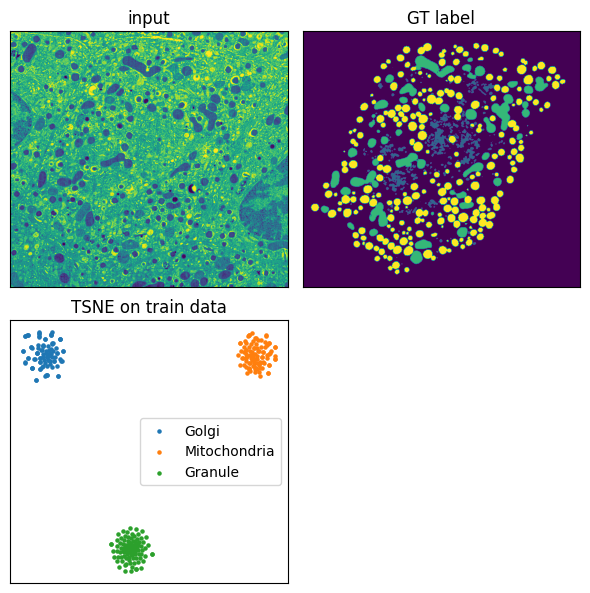

In [19]:
p.plot((test_images[i], "input", False),\
        (test_labels[i], "GT label", False),\
        ([golgi, mitochondria, granule], "TSNE on train data", [('Golgi', 5), ('Mitochondria', 5), ('Granule', 5)]),\
        plot_types=['imshow', 'imshow', 'scatter']
        )

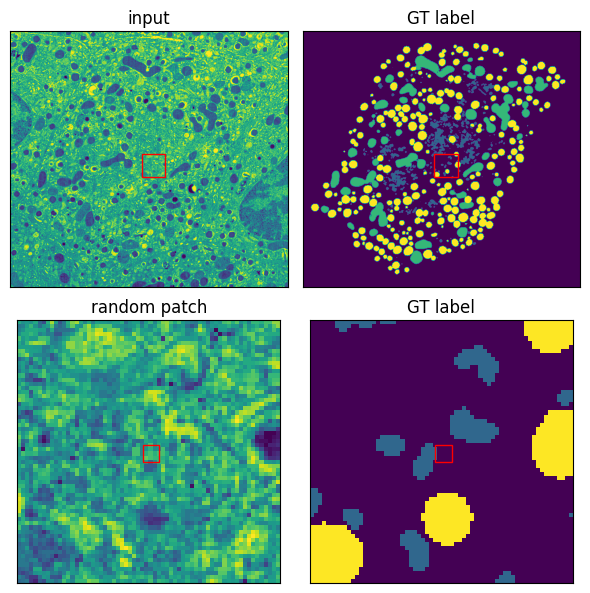

In [74]:
patch, label, y, x = dp.get_random_patch(test_images[i], test_labels[i], patch_size)
feature_map = FE.get_feature_maps(patch)
feature_map = np.expand_dims(feature_map, axis=0)
p.plot( (test_images[i], "input", (y, x, patch_size)),\
        (test_labels[i], "GT label", (y, x, patch_size)),\
        (patch, "random patch", (pad_size, pad_size, centre_size)),\
        (label, "GT label", (pad_size, pad_size, centre_size)),\
        plot_types=['imshow', 'imshow', 'imshow', 'imshow']
        )

In [9]:
# patches, labels = dp.get_all_patches(test_images[i], test_labels[i], patch_size, stride=2)


In [70]:
tsne = []
tsne = TSNE(
    n_components=2,
    random_state=42,
    learning_rate="auto",
    metric="cosine",
    n_iter=10000,
).fit(train_mu)

In [71]:
golgi = tsne[:sample_size]
mitochondria = tsne[sample_size:2*sample_size]
granule = tsne[2*sample_size:]

In [75]:
test_embedding = tsne.transform(feature_map)

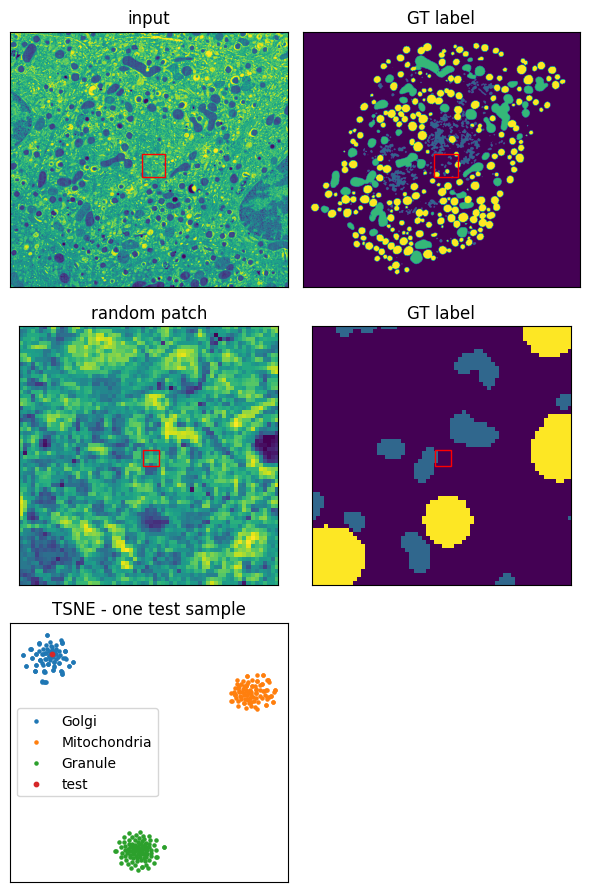

In [76]:
p.plot( (test_images[i], "input", (y, x, patch_size)),\
        (test_labels[i], "GT label", (y, x, patch_size)),\
        (patch, "random patch", (pad_size, pad_size, centre_size)),\
        (label, "GT label", (pad_size, pad_size, centre_size)),\
        ([golgi, mitochondria, granule, test_embedding], "TSNE - one test sample", [('Golgi',5), ('Mitochondria',5), ('Granule',5), ('test',10)]),\
        plot_types=['imshow', 'imshow', 'imshow', 'imshow', 'scatter']
        )

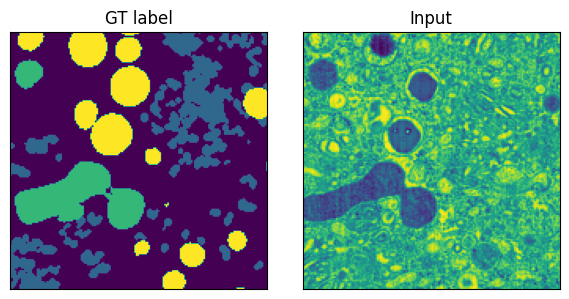

In [84]:
begin = 250
end = 414
p.plot( (test_labels[i][begin:end, begin:end], "GT label", False),\
        (test_images[i][begin:end, begin:end], "Input", False),\
              plot_types=['imshow', 'imshow'])

In [85]:
h, w = test_images[i][begin:end, begin:end].shape
new_h, new_w = h - patch_size + 1, w - patch_size + 1
feature_maps = np.zeros((new_h, new_w))
all_patches, all_labels = dp.get_all_patches(test_images[i][begin:end, begin:end], test_labels[i][begin:end, begin:end], patch_size, stride=1)
idx = 0
for y in tqdm(range(new_h)):
    for x in range(new_w):
        mu = FE.get_feature_maps(all_patches[idx])
        feature_maps[y][x] = FE.get_closest(train_mu, mu)
        idx += 1

100%|██████████| 101/101 [09:03<00:00,  5.38s/it]


In [86]:
dp.save_pickle(f"feature_maps_{i}th_test_sample.pkl", feature_maps)
feature_maps = dp.load_pickle(f"feature_maps_{i}th_test_sample.pkl")


In [87]:
result = np.where(test_labels[i][begin+pad_size:begin+pad_size+101, begin+pad_size:begin+pad_size+101] == feature_maps, feature_maps, 0)

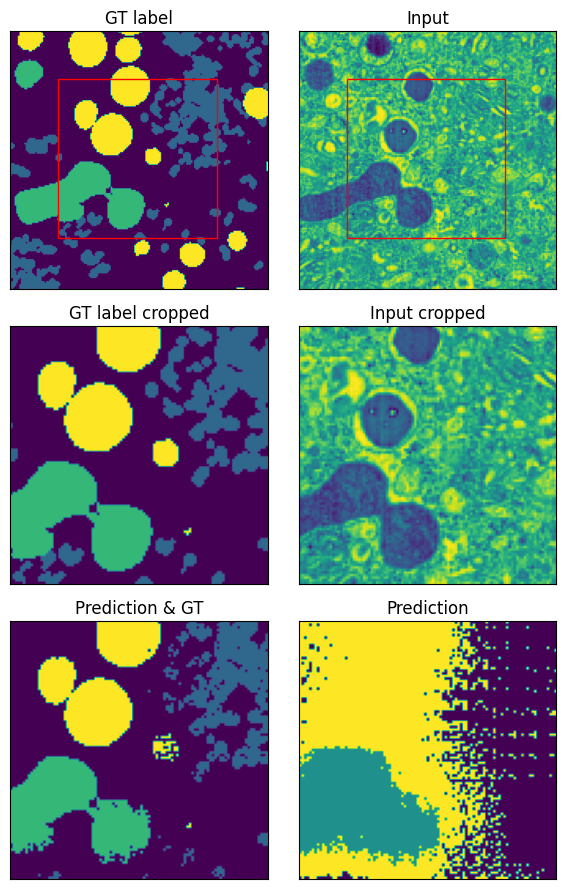

In [88]:
p.plot( (test_labels[i][begin:end, begin:end], "GT label", (pad_size, pad_size, 101)),\
        (test_images[i][begin:end, begin:end], "Input", (pad_size, pad_size, 101)),\
        (test_labels[i][begin+pad_size:begin+pad_size+101, begin+pad_size:begin+pad_size+101], "GT label cropped", False),\
        (test_images[i][begin+pad_size:begin+pad_size+101, begin+pad_size:begin+pad_size+101], "Input cropped", False),\
        (result, "Prediction & GT", False),\
        (feature_maps, "Prediction", False),\
        plot_types=['imshow', 'imshow', 'imshow', 'imshow', 'imshow', 'imshow'])

In [86]:
np.unique(feature_maps, return_counts=True)

(array([1., 2., 3.]), array([2020, 2690, 5491]))

___________________________________________ UMAP & PCA ________________________________________

In [58]:
# Fit UMAP on training data
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
train_embedding = umap_model.fit_transform(train_mu)
test_embedding = umap_model.transform(feature_map)

golgi = train_embedding[:sample_size]
mitochondria = train_embedding[sample_size:2*sample_size]
granule = train_embedding[2*sample_size:]

In [ ]:
p.plot( (test_images[i], "input", (y, x, patch_size)),\
        (test_labels[i], "GT label", (y, x, patch_size)),\
        (patch, "random patch", (pad_size, pad_size, centre_size)),\
        (label, "GT label", (pad_size, pad_size, centre_size)),\
        ([golgi, mitochondria, granule], "UMAP on train data", [('Golgi', 5), ('Mitochondria', 5), ('Granule', 5)]),\
        plot_types=['imshow', 'imshow', 'imshow', 'imshow', 'scatter']
        )

In [ ]:
p.plot( (test_images[i], "input", (y, x, patch_size)),\
        (test_labels[i], "GT label", (y, x, patch_size)),\
        (patch, "random patch", (pad_size, pad_size, centre_size)),\
        (label, "GT label", (pad_size, pad_size, centre_size)),\
        ([golgi, mitochondria, granule, test_embedding], "UMAP - one test sample", [('Golgi',5), ('Mitochondria',5), ('Granule',5), ('test',10)]),\
        plot_types=['imshow', 'imshow', 'imshow', 'imshow', 'scatter', 'scatter']
        )

In [ ]:
pca = PCA(n_components=2)
pca.fit(train_mu)
train_embedding = pca.transform(train_mu)
golgi = train_embedding[:sample_size]
mitochondria = train_embedding[sample_size:2*sample_size]
granule = train_embedding[2*sample_size:]
test_embedding = pca.transform(feature_map)

In [ ]:
p.plot( (test_images[i], "input", (y, x, patch_size)),\
        (test_labels[i], "GT label", (y, x, patch_size)),\
        (patch, "random patch", (pad_size, pad_size, centre_size)),\
        (label, "GT label", (pad_size, pad_size, centre_size)),\
        ([golgi, mitochondria, granule], "PCA on train data", [('Golgi', 5), ('Mitochondria', 5), ('Granule', 5)]),\
        plot_types=['imshow', 'imshow', 'imshow', 'imshow', 'scatter']
        )

In [ ]:
p.plot( (test_images[i], "input", (y, x, patch_size)),\
        (test_labels[i], "GT label", (y, x, patch_size)),\
        (patch, "random patch", (pad_size, pad_size, centre_size)),\
        (label, "GT label", (pad_size, pad_size, centre_size)),\
        ([golgi, mitochondria, granule, test_embedding], "PCA - one test sample", [('Golgi',5), ('Mitochondria',5), ('Granule',5), ('test',10)]),\
        plot_types=['imshow', 'imshow', 'imshow', 'imshow', 'scatter', 'scatter']
        )